# Overview

This notebook uses image embeddings.  Embeddings are a process to convert from feature space into vector space.  Embeddings are used throughout machine learning applications for text, tabular, vision, recommendation problem types.  In this example we will use image embeddings.  We'll convert the images to vector space.  This uses embeddings that were learned via Efficientnet.

Let's get started


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 87 kB 1.8 MB/s  eta 0:00:01
     |████████████████████▊           | 296.1 MB 89.6 MB/s eta 0:00:022

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 458.3 MB 9.8 kB/s s eta 0:00:01
     |████████████████████████████████| 4.0 MB 102.7 MB/s eta 0:00:01
     |████████████████████████████████| 7.0 MB 38.2 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 111.4 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 113.0 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 124.1 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 3.0 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 98.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 64.5 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 87.7 MB/s eta 0:00:01
     |████████████████████████████████| 152 kB 101.9 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 15.0 MB/s  eta 0:00:01
     |████████████████████████████████| 781 kB 96.1 MB/s eta 0:00:01
     |██████████████████████

In [19]:
import image_embeddings
from pathlib import Path
import glob

import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [45]:
# resize user.images
MAX_SIZE = 224
for i in glob.glob('./data/user.images/*.jpg'):
    im = Image.open(i)
    im.thumbnail(size = (MAX_SIZE,MAX_SIZE))
    im.save(i)
    

In [97]:
# resize product.images
MAX_SIZE = 224
for i in glob.glob('./data/product.images/[!aa]*.jpg'):
    im = Image.open(i)
    im.thumbnail(size = (MAX_SIZE,MAX_SIZE))
    im.save(i)

# Get Data

In [18]:
!wget https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar

--2021-09-01 21:10:31--  https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar
Resolving amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)... 52.217.68.244
Connecting to amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)|52.217.68.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3253391360 (3.0G) [application/x-tar]
Saving to: ‘abo-images-small.tar’

100%[====================================>] 3,253,391,360 30.3MB/s   in 2m 22s 

2021-09-01 21:12:53 (21.9 MB/s) - ‘abo-images-small.tar’ saved [3253391360/3253391360]



In [19]:
!tar -xvf abo-images-small.tar -C ./data/product.images --strip-components=3 images/small/

images/small/aa/aa0a1025.jpg
images/small/aa/aa004ab1.jpg
images/small/aa/aa0a486e.jpg
images/small/aa/aa004b77.jpg
images/small/aa/aa0a66c5.jpg
images/small/aa/aa0072ef.jpg
images/small/aa/aa0a6785.jpg
images/small/aa/aa00bdb0.jpg
images/small/aa/aa0a8c77.jpg
images/small/aa/aa00f79d.jpg
images/small/aa/aa0a77e9.jpg
images/small/aa/aa0112ad.jpg
images/small/aa/aa0a95bf.jpg
images/small/aa/aa0139fc.jpg
images/small/aa/aa0aa7ba.jpg
images/small/aa/aa01626f.jpg
images/small/aa/aa0bc0e7.jpg
images/small/aa/aa0173e9.jpg
images/small/aa/aa0bc4ac.jpg
images/small/aa/aa0192cc.jpg
images/small/aa/aa0be0cd.jpg
images/small/aa/aa01afc0.jpg
images/small/aa/aa0bef4d.jpg
images/small/aa/aa01b6d4.jpg
images/small/aa/aa0bf471.jpg
images/small/aa/aa01d10f.jpg
images/small/aa/aa0c1e2a.jpg
images/small/aa/aa01ffb8.jpg
images/small/aa/aa0c1f43.jpg
images/small/aa/aa020a5f.jpg
images/small/aa/aa0c390a.jpg
images/small/aa/aa02896f.jpg
images/small/aa/aa0c81be.jpg
images/small/aa/aa02b776.jpg
images/small/a

In [21]:
!ls ./data/product.images/ | wc -l

1612


In [36]:
# remove all non RGB images from dataset
for i in glob.glob('./data/product.images/*.jpg'):
    im = Image.open(i)
    if im.mode == 'L':
        print(im.mode)
        print(i)
        os.remove(i)
        

In [98]:
home = Path('./data/')
product_images = f"{home}/product.images"
product_tfrecords = f"{home}/product/tfrecords"
product_embeddings = f"{home}/product/embeddings"
user_images = f"{home}/user.images"
user_tfrecords = f"{home}/user/tfrecords"
user_embeddings = f"{home}/user/embeddings"

# Create TFRecords and Embeddings

## PRODUCTS

In [99]:
!rm -r ./data/product.images/.ipynb_checkpoints/
image_embeddings.inference.write_tfrecord(image_folder=product_images,
                                          output_folder=product_tfrecords,
                                          num_shards=10)

Shard 0 saved after 0s
Shard 1 saved after 0s
Shard 2 saved after 0s
Shard 3 saved after 0s
Shard 4 saved after 0s
Shard 5 saved after 0s
Shard 6 saved after 1s
Shard 7 saved after 1s
Shard 8 saved after 1s
Shard 9 saved after 1s


In [100]:
image_embeddings.inference.run_inference(tfrecords_folder=product_tfrecords,
                                         output_folder=product_embeddings,
                                         batch_size=1)

160/160 [==============================] - 5s 28ms/step

Shard 0 done after 5s
Shard 0 saved after 5s
159/159 [==============================] - 5s 28ms/step

Shard 1 done after 9s
Shard 1 saved after 10s
159/159 [==============================] - 4s 28ms/step

Shard 2 done after 14s
Shard 2 saved after 14s
159/159 [==============================] - 4s 28ms/step

Shard 3 done after 19s
Shard 3 saved after 19s
159/159 [==============================] - 4s 27ms/step

Shard 4 done after 23s
Shard 4 saved after 23s
159/159 [==============================] - 4s 27ms/step

Shard 5 done after 28s
Shard 5 saved after 28s
159/159 [==============================] - 4s 28ms/step

Shard 6 done after 32s
Shard 6 saved after 32s
159/159 [==============================] - 4s 28ms/step

Shard 7 done after 37s
Shard 7 saved after 37s
159/159 [==============================] - 4s 28ms/step

Shard 8 done after 41s
Shard 8 saved after 41s
159/159 [==============================] - 4s 27ms/step

Shard 9 do

## USERS

In [101]:
!rm -r ./data/user.images/.ipynb_checkpoints/
image_embeddings.inference.write_tfrecord(image_folder=user_images,
                                          output_folder=user_tfrecords)

rm: cannot remove ‘./data/user.images/.ipynb_checkpoints/’: No such file or directory
Shard 0 saved after 0s
Shard 1 saved after 0s
Shard 2 saved after 0s
Shard 3 saved after 0s
Shard 4 saved after 0s
Shard 5 saved after 0s
Shard 6 saved after 0s
Shard 7 saved after 0s
Shard 8 saved after 0s
Shard 9 saved after 1s


In [102]:
image_embeddings.inference.run_inference(tfrecords_folder=user_tfrecords,
                                         output_folder=user_embeddings,
                                         batch_size=1)

2/2 [==============================] - 1s 31ms/step

Shard 0 done after 1s
Shard 0 saved after 1s
2/2 [==============================] - 0s 31ms/step

Shard 1 done after 1s
Shard 1 saved after 1s
2/2 [==============================] - 0s 33ms/step

Shard 2 done after 1s
Shard 2 saved after 1s
1/1 [==============================] - 0s 66ms/step

Shard 3 done after 1s
Shard 3 saved after 1s
1/1 [==============================] - 0s 63ms/step

Shard 4 done after 1s
Shard 4 saved after 1s
1/1 [==============================] - 0s 62ms/step

Shard 5 done after 1s
Shard 5 saved after 1s
1/1 [==============================] - 0s 62ms/step

Shard 6 done after 1s
Shard 6 saved after 1s
1/1 [==============================] - 0s 64ms/step

Shard 7 done after 2s
Shard 7 saved after 2s
1/1 [==============================] - 0s 66ms/step

Shard 8 done after 2s
Shard 8 saved after 2s
1/1 [==============================] - 0s 65ms/step

Shard 9 done after 2s
Shard 9 saved after 2s


# Embeddings

In [103]:
[product_id_to_name, product_name_to_id, product_embedding] = image_embeddings.knn.read_embeddings(product_embeddings)

In [104]:
[user_id_to_name, user_name_to_id, user_embedding] = image_embeddings.knn.read_embeddings(user_embeddings)

# Nearest Neighbors

In [105]:
index = image_embeddings.knn.build_index(product_embedding)

In [106]:
user_embedding[2].shape

(1280,)

In [129]:
p = 11

fan2


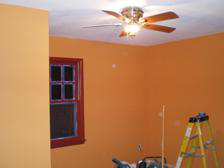

_______
aad27d2c - 82.669677734375


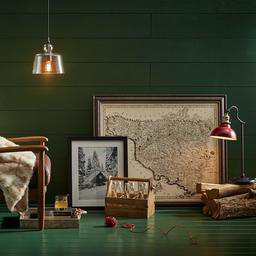

aad16ad8 - 78.54241943359375


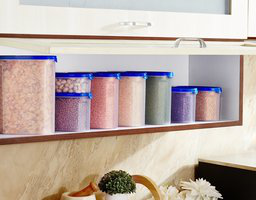

aa87dcda - 75.13343811035156


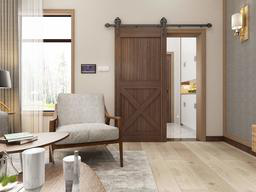

aa58b6ad - 74.86100769042969


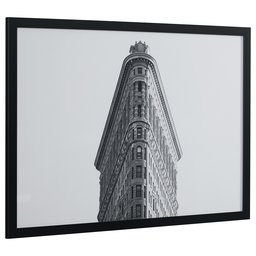

aabd03ce - 74.33735656738281


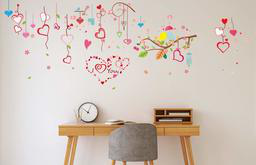

aac842c4 - 72.21007537841797


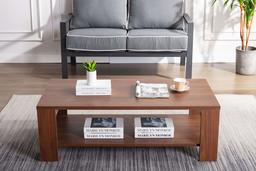

aab9eae0 - 71.9931869506836


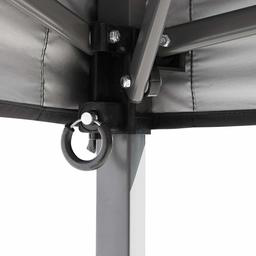

aab18caf - 71.70645141601562


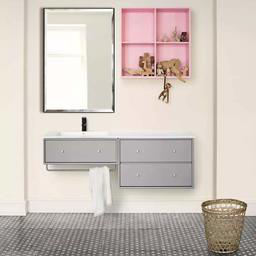

aa9defcf - 71.25190734863281


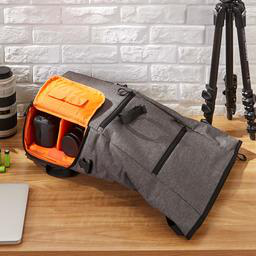

aaaa8ddf - 71.12933349609375


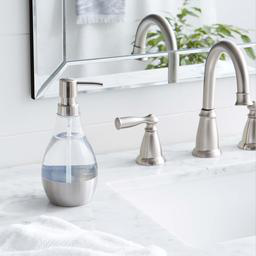

aa419a2f - 70.86890411376953


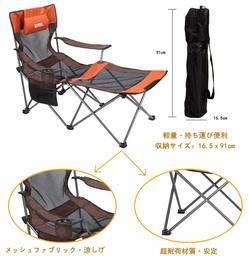

aa843f68 - 70.00888061523438


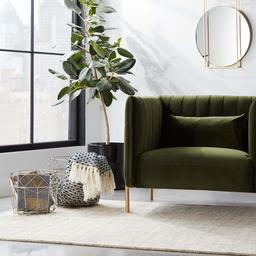

aa0e0248 - 68.95587158203125


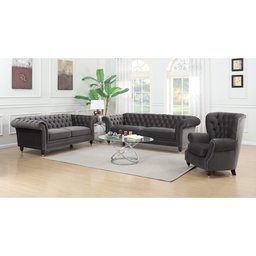

aa0f5304 - 67.8824234008789


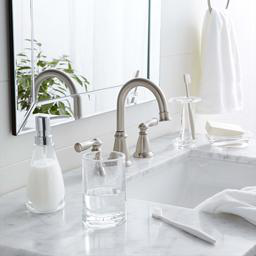

In [130]:
results = image_embeddings.knn.search(index,product_id_to_name,user_embedding[p],k=15)
print(user_id_to_name[p])
Image.open(user_images+'/'+user_id_to_name[p]+'.jpg').show()
print('_______')
for j,i in enumerate(results):
    if j!=0:
        print(f'{i[1]} - {i[0]}')
        img = Image.open(product_images+'/'+i[1]+'.jpg')
        img.show()

# References

* https://github.com/rom1504/image_embeddings